# SPDIS — Strategic Pricing Decision Intelligence Simulator

**Notebook:** BA-focused analysis using behavioral e-commerce data.  
**Tone:** Balanced Professional (executive + e-commerce BA).  

This notebook will:
- Generate synthetic behavioral pricing data (if not present).
- Compute Value Perception Score (VPS).
- Build sensitivity (elasticity) matrix.
- Run 5 business scenarios and shock tests.
- Produce charts and a leadership markdown deck.


In [4]:
# Imports & configuration
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
# ensure we can import src package
import sys
sys.path.append(os.path.abspath(".."))      # so "src" package resolves when running from notebook folder
sys.path.append(os.path.abspath("../src"))

# small display options
pd.set_option("display.max_columns", 40)
pd.set_option("display.width", 160)


In [2]:
# Run only if you don't have src/__init__.py
p = os.path.abspath("../src/__init__.py")
if not os.path.exists(p):
    open(p, "w").close()
    print("Created", p)
else:
    print("src package exists:", p)


src package exists: c:\Users\mshep\Videos\SPDIS\src\__init__.py


In [5]:
# Generate behavioral dataset (safe to run repeatedly)
from src.data_generator import save_behavioral_data

# This writes data to ../data/spdis_behavioral_data.csv
save_behavioral_data()

# Load into dataframe
data_path = os.path.abspath("../data/spdis_behavioral_data.csv")
df = pd.read_csv(data_path)
print("Loaded:", data_path)
df.head()


Synthetic behavioral data saved to: ..\data\spdis_behavioral_data.csv
Loaded: c:\Users\mshep\Videos\SPDIS\data\spdis_behavioral_data.csv


c:\Users\mshep\Videos\SPDIS\src\data_generator.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start, periods=months, freq="M")


,date,product_id,product_type,price,discount_pct,effective_price,competitor_price,interest_score,hesitation_time,scroll_depth,revisit_score,add_to_cart_rate,discount_pref,quality_score,brand_score,perceived_value,season_factor,demand,revenue
0,2023-01-31,P1,Standard,48.10,2.44,46.93,52.44,0.413,16.50,0.638,0.000,0.0279,0.193,0.670,0.593,0.578,1.0,2679.0,125734.37
1,2023-02-28,P1,Standard,48.89,0.00,48.89,59.02,0.684,6.84,0.524,0.053,0.1151,0.175,0.698,0.481,0.650,1.0,4031.0,197059.44
2,2023-03-31,P1,Standard,46.93,0.00,46.93,47.18,0.696,14.19,0.533,0.150,0.1657,0.139,0.649,0.635,0.660,1.0,4880.0,228998.64
3,2023-04-30,P1,Standard,50.70,7.61,46.84,43.28,0.452,15.90,0.599,0.158,0.0534,0.203,0.618,0.581,0.561,1.0,3677.0,172227.11
4,2023-05-31,P1,Standard,58.97,0.00,58.97,52.31,0.714,3.26,0.386,0.087,0.0544,0.152,0.677,0.298,0.612,1.0,2746.0,161943.02


In [6]:
# EDA quick checks
print("Rows,Cols:", df.shape)
display(df.info())
display(df.describe().round(3))


Rows,Cols: (48, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              48 non-null     object 
 1   product_id        48 non-null     object 
 2   product_type      48 non-null     object 
 3   price             48 non-null     float64
 4   discount_pct      48 non-null     float64
 5   effective_price   48 non-null     float64
 6   competitor_price  48 non-null     float64
 7   interest_score    48 non-null     float64
 8   hesitation_time   48 non-null     float64
 9   scroll_depth      48 non-null     float64
 10  revisit_score     48 non-null     float64
 11  add_to_cart_rate  48 non-null     float64
 12  discount_pref     48 non-null     float64
 13  quality_score     48 non-null     float64
 14  brand_score       48 non-null     float64
 15  perceived_value   48 non-null     float64
 16  season_factor     48 non-n

None

,price,discount_pct,effective_price,competitor_price,interest_score,hesitation_time,scroll_depth,revisit_score,add_to_cart_rate,discount_pref,quality_score,brand_score,perceived_value,season_factor,demand,revenue
count,48.000,48.000,48.000,48.000,48.000,48.000,48.000,48.000,48.000,48.000,48.000,48.000,48.000,48.000,48.000,48.000
mean,68.953,1.249,68.065,71.457,0.625,10.721,0.522,0.091,0.060,0.142,0.727,0.578,0.667,1.067,3239.542,206212.016
std,21.144,2.681,20.905,22.380,0.163,5.318,0.216,0.066,0.040,0.104,0.155,0.145,0.110,0.100,961.891,47581.331
min,37.700,-1.220,37.700,39.700,0.340,1.950,0.021,0.000,0.001,0.000,0.459,0.298,0.435,1.000,1125.000,106637.940
25%,48.880,0.000,48.630,50.880,0.474,6.668,0.378,0.039,0.032,0.046,0.616,0.476,0.577,1.000,2522.250,172101.222
50%,62.585,0.000,59.535,66.655,0.636,10.020,0.525,0.088,0.058,0.140,0.734,0.558,0.656,1.000,3118.500,199729.970
75%,90.295,0.700,87.398,92.145,0.714,14.538,0.642,0.136,0.075,0.217,0.867,0.677,0.748,1.150,3992.000,233615.692
max,105.940,11.980,105.940,110.780,1.000,23.020,1.000,0.241,0.181,0.368,0.988,0.934,0.877,1.250,5293.000,331929.660


In [7]:
from src.vps_engine import add_vps_column

df = add_vps_column(df)
display(df[["date","product_id","product_type","effective_price","vps","demand"]].head(8))
print("VPS median:", round(df["vps"].median(),3))


,date,product_id,product_type,effective_price,vps,demand
0,2023-01-31,P1,Standard,46.93,0.49505,2679.0
1,2023-02-28,P1,Standard,48.89,0.57395,4031.0
2,2023-03-31,P1,Standard,46.93,0.58220,4880.0
3,2023-04-30,P1,Standard,46.84,0.48055,3677.0
4,2023-05-31,P1,Standard,58.97,0.54835,2746.0
5,2023-06-30,P1,Standard,48.85,0.47275,3979.0
6,2023-07-31,P1,Standard,44.26,0.50510,4684.0
7,2023-08-31,P1,Standard,39.47,0.50510,4449.0


VPS median: 0.578


In [8]:
from src.sensitivity_matrix import build_sensitivity_matrix

prod = "P1"
df_p1 = df[df["product_id"] == prod].copy()
mat = build_sensitivity_matrix(df_p1)
mat


,segment,competitor_action,elasticity
0,Loyal,undercut,-2.2
1,Loyal,neutral,-1.2
2,Loyal,premium,-1.0
3,Premium,undercut,-1.8
4,Premium,neutral,-1.2
5,Premium,premium,-1.0
6,Bargain,undercut,-2.2
7,Bargain,neutral,-1.6
8,Bargain,premium,-1.4


In [9]:
from src.scenario_engine import run_scenarios

base_price = df_p1["effective_price"].median()
cost_estimate = base_price * 0.6   # BA assumption for demo
scenarios = run_scenarios(df_p1, base_price, cost_estimate)
import pprint
pprint.pprint(scenarios)


{'Best': {'candidate_price': 48.41,
          'predicted_demand': 3676,
          'predicted_revenue': 177949.32,
          'reason': 'ok'},
 'Competitor_Undercut': {'candidate_price': 48.41,
                         'predicted_demand': 2877,
                         'predicted_revenue': 139264.69,
                         'reason': 'ok'},
 'Expected': {'candidate_price': 48.41,
              'predicted_demand': 3196,
              'predicted_revenue': 154738.54,
              'reason': 'ok'},
 'Festival_Surge': {'candidate_price': 48.41,
                    'predicted_demand': 3996,
                    'predicted_revenue': 193423.18,
                    'reason': 'ok'},
 'Worst': {'candidate_price': 48.41,
           'predicted_demand': 2717,
           'predicted_revenue': 131527.76,
           'reason': 'ok'}}


In [10]:
from src.shock_simulator import apply_shock

print("Base avg demand:", int(df_p1["demand"].mean()))
print("Festival shock (25%):", apply_shock(df_p1, shock_type="festival", intensity=0.25))
print("Competitor flash (25%):", apply_shock(df_p1, shock_type="competitor_flash", intensity=0.25))


Base avg demand: 3835
Festival shock (25%): 4794
Competitor flash (25%): 2876


Price ladder: {'entry': np.float64(43.57), 'mid': np.float64(48.41), 'premium': np.float64(55.67)}


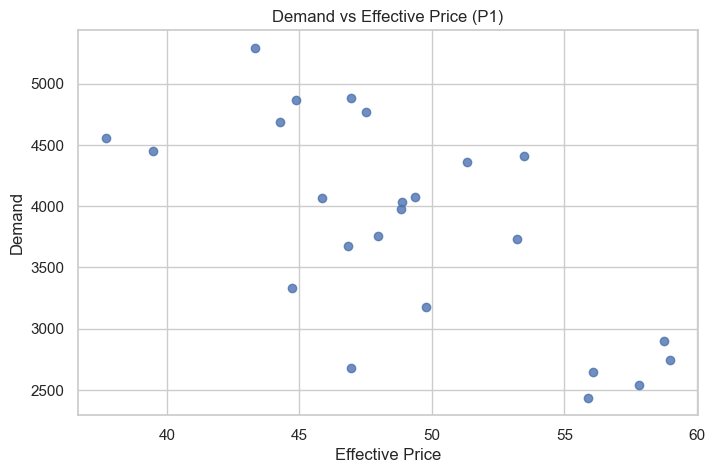

In [11]:
from src.price_ladder import generate_price_ladder
from src.utils import save_chart

ladder = generate_price_ladder(df_p1, base_price)
print("Price ladder:", ladder)

# Demand vs price scatter
plt.figure(figsize=(8,5))
plt.scatter(df_p1["effective_price"], df_p1["demand"], alpha=0.8)
plt.title(f"Demand vs Effective Price ({prod})")
plt.xlabel("Effective Price")
plt.ylabel("Demand")
save_chart(plt, os.path.abspath("../charts/demand_vs_price_p1.png"))
plt.show()


Using elasticity: -1.4


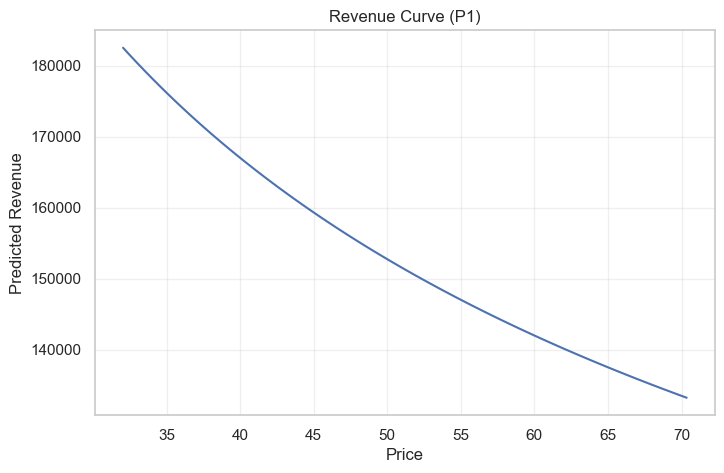

Optimal price (approx): 32.04


In [12]:
import numpy as np
from src.utils import save_chart

# pick elasticity from matrix median (fallback -1.3)
elas = mat["elasticity"].median()
if np.isnan(elas):
    elas = -1.3
print("Using elasticity:", round(elas,3))

# build price grid around observed prices
pmin = df_p1["effective_price"].quantile(0.05) * 0.8
pmax = df_p1["effective_price"].quantile(0.95) * 1.2
prices = np.linspace(pmin, pmax, 80)

# base demand
base_demand = df_p1["demand"].mean()
median_vps = df_p1["vps"].median()
revenues = []
demands = []
for p in prices:
    price_factor = (p / base_price) ** elas
    d = max(0, base_demand * price_factor * (median_vps/0.6))
    revenues.append(d * p)
    demands.append(d)

# plot revenue curve
plt.figure(figsize=(8,5))
plt.plot(prices, revenues, label="Predicted Revenue")
plt.xlabel("Price")
plt.ylabel("Predicted Revenue")
plt.title(f"Revenue Curve ({prod})")
plt.grid(alpha=0.3)
save_chart(plt, os.path.abspath("../charts/revenue_curve_p1.png"))
plt.show()

# show optimal
opt_idx = int(np.argmax(revenues))
print("Optimal price (approx):", round(prices[opt_idx],2))


In [13]:
from src.deck_generator import generate_deck_md

insights = [
    "Bargain segment shows strongest elasticity when competitor undercuts.",
    "Higher VPS aligns with higher add-to-cart rates and lower hesitation."
]
recs = [
    "Adopt mid-tier pricing with targeted discounts for Bargain segment during competitor price wars.",
    "Enforce guardrails to protect margin; monitor competitor price weekly."
]
deck_path = generate_deck_md(insights=insights, recommendations=recs)
print("Deck generated at:", deck_path)
# show file contents quickly
print(open(deck_path, "r", encoding="utf-8").read())


Deck generated at: ..\notebook\spdis_leadership_deck.md
# SPDIS Leadership Brief — 2025-12-03

## Key Insights

1. Bargain segment shows strongest elasticity when competitor undercuts.
2. Higher VPS aligns with higher add-to-cart rates and lower hesitation.

## Recommendations

1. Adopt mid-tier pricing with targeted discounts for Bargain segment during competitor price wars.
2. Enforce guardrails to protect margin; monitor competitor price weekly.



In [ ]:
import sys, os
print("Notebook cwd:", os.getcwd())
print("sys.path (first 6 entries):")
for p in sys.path[:6]:
    print("  ", p)
import importlib
print("\nCan we import src? ->", importlib.util.find_spec("src") is not None)


## Conclusion — BA summary

- We generated behavioral e-commerce dataset and computed VPS.
- Sensitivity matrix gives interpretable elasticity by segment and competitor action.
- Scenario engine produced five business scenarios with predicted demand & revenue.
- Leadership deck (markdown) has been auto-generated: `notebook/spdis_leadership_deck.md`.

**Next steps (BA):**
1. Validate assumptions with a stakeholder (e.g., confirm cost estimate and margin thresholds).  
2. Extend dataset with additional behavioral signals if available (e.g., session source, promo channel).  
3. Convert deck markdown to slides/PDF for leadership presentation.
